In [13]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

C=3e8  # Speed of light in m/s

Utilities

In [14]:
# 유틸: dBm <-> W 변환
def dbm_to_w(dBm):
    return 10**((dBm - 30) / 10.0)

def w_to_dbm(W):
    return 10 * np.log10(W) + 30

In [15]:
# λ/2(local) 제약을 자동으로 쓰기 위한 헬퍼들
def local_radius(fc, factor=0.5):
    """
    주파수 fc[Hz]로부터 파장 λ를 계산하고 허용 반경 r_max = factor*λ 반환.
    기본 factor=0.5 -> λ/2.
    """
    lam = C / float(fc)
    return factor * lam, lam

# --- λ/2 내 단일 축 선형 스캔 좌표 생성
def scan_along_axis(center, fc, axis='x', num=5, factor=0.5, span_ratio=1.0):
    """
    λ/2 반경 내에서 단일 축으로 선형 스캔 좌표를 자동 생성.
      - center: [x,y,z] (지역 기준점)
      - axis: 'x'|'y'|'z'
      - num: 샘플 개수
      - factor: 허용 반경 계수(0.5 -> λ/2)
      - span_ratio: 실제 스캔 폭 / r_max (1.0이면 ±r_max까지)
    반환: (N,3) numpy 배열
    """
    r_max, _ = local_radius(fc, factor)
    span = span_ratio * r_max
    c = np.asarray(center, float).copy()
    coords = []
    idx = {'x':0, 'y':1, 'z':2}[axis.lower()]
    for delta in np.linspace(-span, span, num):
        p = c.copy()
        p[idx] += delta
        if np.linalg.norm(p - c) <= r_max + 1e-12:  # 안전 체크
            coords.append(p)
    return np.array(coords)

# --- λ/2 '구(볼)' 내부 3D 격자 샘플 생성
def grid_in_ball(center, fc, num_per_axis=5, factor=0.5, span_ratio=1.0):
    """
    λ/2 '구(볼)' 내부의 3D 격자 샘플 자동 생성.
      - 먼저 [-span, span]^3 그리드를 만들고
      - 반경 r_max 바깥 점은 제거.
    반환: (N,3) numpy 배열
    """
    r_max, _ = local_radius(fc, factor)
    span = span_ratio * r_max
    c = np.asarray(center, float)

    axes = [np.linspace(-span, span, num_per_axis) for _ in range(3)]
    X, Y, Z = np.meshgrid(*axes, indexing='ij')
    dxyz = np.stack([X, Y, Z], axis=-1).reshape(-1, 3)

    mask = np.linalg.norm(dxyz, axis=1) <= (r_max + 1e-12)
    return c + dxyz[mask]

# --- λ/2 반경 밖 좌표를 경계로 투영(클램프)
def clamp_to_lambda2(rx_pos, center, fc, factor=0.5):
    """
    주어진 rx_pos가 λ/2 반경 밖이면, 중심에서 r_max 방향으로 '클램프'하여
    반경 경계로 투영한 좌표를 반환. (평면파 가정 강제 유지용)
    """
    r_max, _ = local_radius(fc, factor)
    p = np.asarray(rx_pos, float)
    c = np.asarray(center, float)
    v = p - c
    dist = np.linalg.norm(v)
    if dist <= r_max + 1e-12:
        return p
    if dist < 1e-12:
        return c  # 동일점
    return c + v * (r_max / dist)

Channel & Performance

In [16]:
# 핵심 함수: 수신 전력 계산 (3D, single user, fully-MA)
def received_power_dBm(
    tx_pos,                 # TX 3D 좌표 (x,y,z) [m]
    rx_pos,                 # RX(MA) 3D 좌표 (x,y,z) [m]  <-- 연속적으로 바꿔가며 호출 가능
    fc,                     # 반송파 주파수 [Hz]
    Pt_dBm,                 # 송신 전력 [dBm]
    Gt_dBi=0.0,             # 송신 안테나 이득 [dBi]
    Gr_dBi=0.0,             # 수신 안테나 이득 [dBi]
    multipath=None,         # 다중경로 리스트: [(alpha, extra_len_m), ...]  (옵션)
                            #  - alpha: 경로의 복소 진폭(반사/산란 감쇠 및 위상 포함, 상대 규모)
                            #  - extra_len_m: LOS 대비 추가 경로 길이 [m]
    shadowing_dB=0.0,       # 로그정규 그림자 페이딩 [dB] (옵션, 필요 없으면 0)
    region_center=None,     # MA 지역 기준점(예: 장착 지점)
    enforce_local_pw=True,  # 평면파(local) 제약 검사 ON/OFF
    local_radius_factor=0.5 # 허용 반경 = local_radius_factor * λ (기본: λ/2)
):
    """
    3D에서 임의의 RX 위치(fully-MA)에 대해 수신 전력 Pr[dBm]과 채널 전력이득 |h|^2 를 반환.
    모델:
      - LOS: Friis 링크버짓 사용
      - 다중경로: LOS 기준으로 (alpha, extra_len)로 지정된 필드를 위상합성 (상대 모델)
      - 최종 Pr = Pt * Gt * Gr * (λ/(4πd_LOS))^2 * |h|^2  (dBm 스케일)

    인자 설명:
      tx_pos, rx_pos: 길이 3의 시퀀스(리스트/튜플/ndarray)
      multipath: [(alpha, extra_len_m), ...]
                 예) [(0.4*np.exp(1j*np.pi/3), 0.8), (0.2, 1.7)]
    """
    # --- 좌표를 numpy 배열로 정리
    tx_pos = np.asarray(tx_pos, dtype=float)
    rx_pos = np.asarray(rx_pos, dtype=float)

    # --- 파장 계산
    lam = C / float(fc)

    # ---- 평면파(local) 제약 검사 ----
    if enforce_local_pw and (region_center is not None):
        center = np.asarray(region_center, float)
        r = np.linalg.norm(rx_pos - center)
        r_max = local_radius_factor * lam   # 기본 λ/2
        if r > r_max + 1e-12:
            raise ValueError(
                f"[Plane-wave constraint] MA displacement {r:.3f} m exceeds allowed radius {r_max:.3f} m "
                f"(≈ {local_radius_factor}·λ, λ={lam:.3f} m). "
                "Use a near-field/spherical model or reduce movement."
            )

    # --- LOS 거리
    d_los = np.linalg.norm(rx_pos - tx_pos) + 1e-12  # 0 division 방지용 작은 값

    # --- Friis 경로손실 계수(전력 기준): (λ/(4πd))^2  → dB 스케일로는 -Lfs_dB
    Lfs_dB = 20 * np.log10(4 * np.pi * d_los / lam)  # free-space path loss in dB

    # --- 복소 채널 계수 h: 경로들의 '필드'를 위상합성
    #     기준을 LOS에 두고, LOS의 상대 진폭을 1로 둠
    h = np.exp(-1j * 2 * np.pi * d_los / lam)  # LOS 위상 성분 (진폭=1, 기준)

    # --- 선택적 다중경로 합성
    if multipath is not None:
        for alpha, extra_len in multipath:
            # 각 경로의 총 거리 = d_los + extra_len  (단순 모델: LOS 대비 우회 길이만큼 더 감)
            d_path = d_los + float(extra_len)
            # 해당 경로의 위상 (2π·거리/λ)
            phase = np.exp(-1j * 2 * np.pi * d_path / lam)
            # LOS 대비 상대 진폭 alpha를 곱해 합성
            h += alpha * phase

    # --- 채널 전력 이득 |h|^2 (필드 합성의 제곱 크기)
    power_gain = np.abs(h)**2

    # --- 링크버짓 결합 (dBm 스케일)
    #     Pr[dBm] = Pt + Gt + Gr - Lfs + 10log10(|h|^2) + shadowing
    Pr_dBm = Pt_dBm + Gt_dBi + Gr_dBi - Lfs_dB + 10 * np.log10(power_gain + 1e-30) + shadowing_dB

    return Pr_dBm, power_gain

In [17]:
# SNR 계산 함수
def snr_dB(Pr_dBm, noise_figure_dB=5.0, BW=20e6, T=290.0):
    """
    열잡음 바닥을 고려한 SNR[dB] 계산.
      N0[W] = kTB,  N0[dBm] = 10log10(kTB) + 30
      N[dBm] = N0[dBm] + NF[dB]
      SNR[dB] = Pr[dBm] - N[dBm]
    """
    k = 1.380649e-23  # 볼츠만 상수
    N0_W = k * T * BW
    N0_dBm = 10*np.log10(N0_W) + 30
    N_dBm  = N0_dBm + noise_figure_dB
    return Pr_dBm - N_dBm

Simulation settings

In [18]:
fc = 5.2e9                 # 5.2 GHz
Pt = 20.0                  # 20 dBm TX power
Gt, Gr = 8.0, 8.0          # 8 dBi 송/수 이득
tx = [0.0, 0.0, 5.0]
rx = [30.0, 2.0, 1.5]      # RX(MA)
region_center = [30.0, 2.0, 1.5]   # MA 지역 기준점

# A) 단일 위치에서 Pr / SNR 계산 (기존 코드)
multipath = [
    (0.35 * np.exp(1j * np.pi / 4), 0.9),
    (0.20 * np.exp(-1j * np.pi / 3), 1.7),
]

rx = [30.0, 2.0, 1.5]      # RX(MA)

Pr_dBm, g = received_power_dBm(
    tx, rx, fc, Pt, Gt, Gr, multipath,
    region_center=region_center,
    enforce_local_pw=True, local_radius_factor=0.5
)

print(f"[Single point] Pr = {Pr_dBm:.2f} dBm, |h|^2 = {g:.3f}")
print(f"[Single point] SNR ≈ {snr_dB(Pr_dBm, noise_figure_dB=5, BW=20e6):.2f} dB")

# B) λ/2 내 x축 선형 스캔
line_pts = scan_along_axis(region_center, fc, axis='x', num=5, factor=0.5, span_ratio=1.0)
print("\n[Line scan ±λ/2 along x]")
for rx in line_pts:
    Pr, g = received_power_dBm(
        tx, rx, fc, Pt_dBm=Pt, Gt_dBi=Gt, Gr_dBi=Gr,
        multipath=[(0.3*np.exp(1j*np.pi/4), 0.8)],
        region_center=region_center,
        enforce_local_pw=True, local_radius_factor=0.5
    )
    print(f"  rx={rx} -> Pr={Pr:.2f} dBm, |h|^2={g:.3f}")

# C) λ/2 구(볼) 내부 3D 격자 샘플
ball_pts = grid_in_ball(region_center, fc, num_per_axis=7, factor=0.5, span_ratio=1.0)
Pr_list = []
for rx in ball_pts:
    Pr, g = received_power_dBm(
        tx, rx, fc, Pt_dBm=Pt, Gt_dBi=Gt, Gr_dBi=Gr,
        multipath=[(0.35*np.exp(1j*np.pi/4), 0.9),
                   (0.2*np.exp(-1j*np.pi/3), 1.7)],
        region_center=region_center,
        enforce_local_pw=True, local_radius_factor=0.5
    )
    Pr_list.append(Pr)
print(f"\n[Ball grid] points={len(ball_pts)}, Pr(dBm) min={np.min(Pr_list):.2f}, "
      f"max={np.max(Pr_list):.2f}, mean={np.mean(Pr_list):.2f}")

# D) λ/2 밖 좌표를 경계로 클램프해서 사용
rx_far = [region_center[0] + 0.05, region_center[1], region_center[2]]  # 5 cm
rx_safe = clamp_to_lambda2(rx_far, region_center, fc, factor=0.5)
Pr, g = received_power_dBm(
    tx, rx_safe, fc, Pt_dBm=Pt, Gt_dBi=Gt, Gr_dBi=Gr,
    region_center=region_center,
    enforce_local_pw=True, local_radius_factor=0.5
)
print(f"\n[Clamp] rx_far={rx_far} -> rx_safe={rx_safe}, Pr={Pr:.2f} dBm, |h|^2={g:.3f}")

[Single point] Pr = -45.91 dBm, |h|^2 = 0.280
[Single point] SNR ≈ 50.05 dB

[Line scan ±λ/2 along x]
  rx=[29.97115385  2.          1.5       ] -> Pr=-40.13 dBm, |h|^2=1.059
  rx=[29.98557692  2.          1.5       ] -> Pr=-40.13 dBm, |h|^2=1.059
  rx=[30.   2.   1.5] -> Pr=-40.13 dBm, |h|^2=1.059
  rx=[30.01442308  2.          1.5       ] -> Pr=-40.14 dBm, |h|^2=1.059
  rx=[30.02884615  2.          1.5       ] -> Pr=-40.14 dBm, |h|^2=1.059

[Ball grid] points=123, Pr(dBm) min=-45.92, max=-45.91, mean=-45.91

[Clamp] rx_far=[30.05, 2.0, 1.5] -> rx_safe=[30.02884615  2.          1.5       ], Pr=-40.39 dBm, |h|^2=1.000


In [19]:
def _set_equal_3d(ax):
    """3D equal aspect ratio (x=y=z)"""
    x_limits = ax.get_xlim3d(); y_limits = ax.get_ylim3d(); z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    plot_radius = 0.5 * max([x_range, y_range, z_range])
    x_middle = np.mean(x_limits); y_middle = np.mean(y_limits); z_middle = np.mean(z_limits)
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def plot_ma_scene_3d(
    tx_pos,
    region_center,
    current_rx=None,
    line_pts=None,
    ball_pts=None,
    r_max=None,             # λ/2 등 구 반경
    title="MA 3D Scene",
    save_path=None,
    show=True
):
    """
    3D에서 Tx / MA 중심 / 표본 좌표들(라인/볼) 시각화
    """
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    tx_pos = np.asarray(tx_pos, float)
    cen = np.asarray(region_center, float)

    # Tx / Center
    ax.scatter([tx_pos[0]], [tx_pos[1]], [tx_pos[2]], marker='^', s=80, label='Tx')
    ax.scatter([cen[0]], [cen[1]], [cen[2]], marker='o', s=50, label='MA center')

    # Current Rx
    if current_rx is not None:
        crx = np.asarray(current_rx, float)
        ax.scatter([crx[0]], [crx[1]], [crx[2]], marker='x', s=60, label='Current Rx')

    # Line scan
    if line_pts is not None and len(line_pts) > 0:
        lp = np.asarray(line_pts, float)
        ax.scatter(lp[:, 0], lp[:, 1], lp[:, 2], marker='.', s=14, label='Line scan')

    # Ball grid
    if ball_pts is not None and len(ball_pts) > 0:
        bp = np.asarray(ball_pts, float)
        ax.scatter(bp[:, 0], bp[:, 1], bp[:, 2], marker='.', s=8, alpha=0.6, label='Ball grid')

    # Sphere (r_max)
    if r_max is not None and r_max > 0:
        u = np.linspace(0, 2*np.pi, 36)
        v = np.linspace(0, np.pi, 18)
        xs = cen[0] + r_max * np.outer(np.cos(u), np.sin(v))
        ys = cen[1] + r_max * np.outer(np.sin(u), np.sin(v))
        zs = cen[2] + r_max * np.outer(np.ones_like(u), np.cos(v))
        ax.plot_wireframe(xs, ys, zs, linewidth=0.5, alpha=0.5, color='gray')

    ax.set_xlabel('x [m]'); ax.set_ylabel('y [m]'); ax.set_zlabel('z [m]')
    ax.set_title(title)
    ax.legend(loc='best')
    _set_equal_3d(ax)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    if show:
        plt.show()


Draw 3D scene

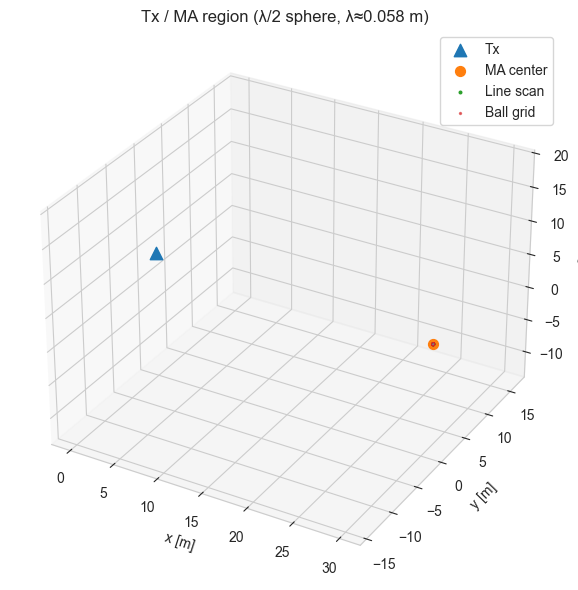

In [20]:
r_max, lam = local_radius(fc, factor=0.5)
plot_ma_scene_3d(
    tx_pos=tx,
    region_center=region_center,
    current_rx=None,        # 강조하고 싶은 좌표가 있으면 지정
    line_pts=line_pts,
    ball_pts=ball_pts,
    r_max=r_max,
    title=f"Tx / MA region (λ/2 sphere, λ≈{lam:.3f} m)"
)

Line scan Pr(dBm) curve

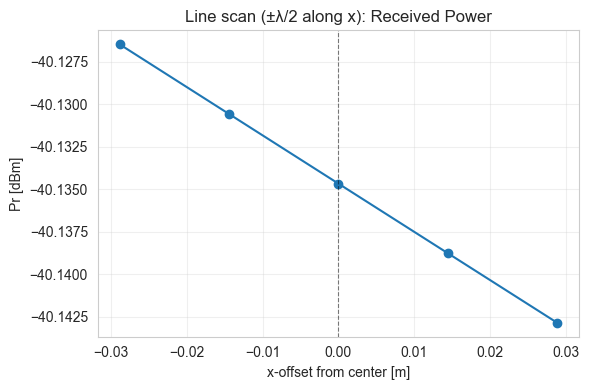

In [21]:
# 라인 스캔 offset (x축 기준)의 상대 변화량과 Pr 계산
offsets = line_pts[:, 0] - region_center[0]
Pr_curve = []
for p in line_pts:
    Pr, _ = received_power_dBm(
        tx, p, fc, Pt_dBm=Pt, Gt_dBi=Gt, Gr_dBi=Gr,
        multipath=[(0.3 * np.exp(1j * np.pi / 4), 0.8)],
        region_center=region_center, enforce_local_pw=True, local_radius_factor=0.5
    )
    Pr_curve.append(Pr)

plt.figure(figsize=(6,4))
plt.plot(offsets, Pr_curve, marker='o')
plt.axvline(0, color='k', linewidth=0.8, linestyle='--', alpha=0.5)
plt.title("Line scan (±λ/2 along x): Received Power")
plt.xlabel("x-offset from center [m]")
plt.ylabel("Pr [dBm]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Histogram of received power over λ/2 ball samples

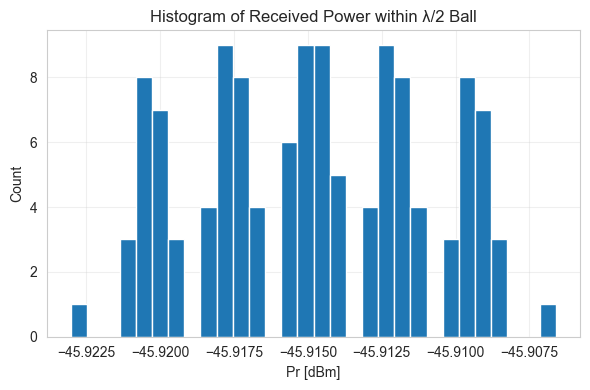

Samples: 123, min=-45.92 dBm, max=-45.91 dBm, mean=-45.91 dBm, std=0.00 dB


In [22]:
if 'ball_pts' not in globals():
    ball_pts = grid_in_ball(region_center, fc, num_per_axis=7, factor=0.5, span_ratio=1.0)

Pr_list = []
for p in ball_pts:
    Pr, _ = received_power_dBm(
        tx, p, fc, Pt_dBm=Pt, Gt_dBi=Gt, Gr_dBi=Gr,
        multipath=[(0.35 * np.exp(1j * np.pi / 4), 0.9),
                   (0.2 * np.exp(-1j * np.pi / 3), 1.7)],
        region_center=region_center, enforce_local_pw=True, local_radius_factor=0.5
    )
    Pr_list.append(Pr)
Pr_list = np.array(Pr_list)

plt.figure(figsize=(6,4))
plt.hist(Pr_list, bins=30)
plt.title("Histogram of Received Power within λ/2 Ball")
plt.xlabel("Pr [dBm]")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Samples: {len(Pr_list)}, min={Pr_list.min():.2f} dBm, "
      f"max={Pr_list.max():.2f} dBm, mean={Pr_list.mean():.2f} dBm, std={Pr_list.std():.2f} dB")
